In [65]:
# Virtual Environment
# All the units are in SI system
import numpy as np
# 

def Matrial_on_the_road(Air_temp, Suraface_temp, Precipitation, wind_vel,initial_Snow, initial_water, initial_Salt, initial_ice, plowing):
    # General assumptions:
    Dataset_hour_inc = 1 # *3 had applied in the dataset
    f_t = 0.9 #times when the road is covered with moving vehicle
    g_t = 1 - f_t
    
    
    
    # convert Precipitation to snow or rain based on the air temp
    if Air_temp < .5:
        Snowfall_amount = Precipitation
        Rainfall_amount = 0
    else:
        Rainfall_amount = Precipitation
        Snowfall_amount = 0
    
    ###### Heat Ballance ##########################################################################################################
    # Q_csp : Flux of pavement heat
    V_wis = initial_ice + initial_Snow + Snowfall_amount # Volume of WIS layer (m3*m-2 = m) depth of material on the road
    V_ps = 50e-3 # thikness of pavement surface, generally 25 to 55 mm, here we assume 50mm
    Lambda_wis = 0.8 # thermal conductivity of WIS layer. Assume that is compacted snow 
    Lambda_P = 1.5 # Thermal conductivity of pavemetn. 0.8 to 2
    T_wis = (Air_temp + Suraface_temp)/2 #Temp of wis layer: assumption 
    Q_csp = 1/((V_wis/(2*Lambda_wis))+(V_ps/(2*Lambda_P)))*(Suraface_temp - T_wis)
    
     # Q_rn : Flux of net radient heat
    q_rld = 20 #Since we are modeling the winter stroms, the sky radiation shouldn't be high 0-200
    q_rlu = 0.97 * 5.64e-8 * (T_wis + 273.15)**4
    q_rsd = 20 #Since we are modeling the winter stroms, the sky radiation shouldn't be high 0-300
    q_rsu = 0.3 * q_rsd
    Q_rn = f_t*q_rld + q_rlu + f_t*q_rsd - q_rsu
    
    # Q_sn Flux of net radiant heat
    q_sa = (10e4 * wind_vel**0.7 +2.2)*(T_wis - Air_temp)#snesable heat flux due to wind
    q_sf = (4.184* (initial_water + Rainfall_amount) + 2.108 * (initial_ice  + initial_Snow + Snowfall_amount))# Sensable heat flux due to rainfall and snowfall
    q_sr = 0 #Sensible heat flux of drainage due to road gradient assume = 0
    q_sv = 4.184 * T_wis * 1000 * 0.5 * 0.005/3600 * 0.15#sensible heat flux of water dispersion due to passing vehicle
    Q_sn = q_sa + f_t*q_sf + q_sr + g_t * q_sv
    
    # Q_ln flux of net latent heat
    # m_wi * L_wi is not considered here, we will change the q_net relation with M_wi later
    m_il = 0 # sublimation flux
    L_i = 2838 #kJkg-1 latent heat of sublimation
    m_wl = 0 # flux of evaporation and condensation
    L_w = 2260 #kJkg-1 latent heat of evaporation and condensation
    m_sl = 3.34e-5 # dissolving flux (0 - 6.67e-5) if salting
    L_s = -66.4 # latent heat of dissolution of salt 
    Q_ln = m_il*L_i + m_wl*L_w + m_sl*L_s
    
    # Q_vn flux of net vehicle heat
    Q_vn = 100 #assumption according to Fujimoto and other citations
    
    # Q_net
    Q_net = Q_csp + Q_rn + Q_sn + Q_ln + Q_vn
    #################################################################################################################################
    #*******************************************************************************************************************************#
    
    ## Material creation $$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
    # Ice 
    Ice_final = initial_ice 
    
    # Snowfall 
    m_snowf = Snowfall_amount * Dataset_hour_inc * 100 # 100 kg/m3
    Snow_creat = m_snowf * f_t
    Snow_final = Snow_creat + initial_Snow
    # plowing  $$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
    if plowing == 1:
        Snow_final *= 0.1
        
    # or rainfall
    m_wf = Rainfall_amount * Dataset_hour_inc * 1000 # 1000 kg/m3
    Rain_creat = m_wf * f_t
    Water_final = Rain_creat + initial_water
    # before mesuring the water to ice, we have to consider the water dispersion
    # Water dispersion
    # Assume we have good drainage system
    Water_final = Water_final * 0.95
    
    #Salt
    # Salt_final = initial_Salt * 0.5# Maybe need conversion
    
    ### Material Conversion $$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
    ## Snow to ice
    Snow_To_Ice_rate = 0.1 # Assumption: conversion applied to initial snow 
    Ice_final += Snow_To_Ice_rate * initial_Snow
    
    ## water to ice or vise versa *
    L_wi = 334 #kJkg-1 latent heat of melting and freezing
    Water_ice_conv_mass = abs(Q_net/(L_wi*999))
    # We will assume that the water freezing point is just a function of salt concentration
    T_frezzing = -0.025 * initial_Salt - 0.5
    # print("TF",T_frezzing)
    
    if T_wis > T_frezzing:
        STATUS = "Melting"
        # print("###############################Melting")  # Melting
        stat_sign = 1
        Ice_final = Ice_final - min(Water_ice_conv_mass, Ice_final)  
        Water_final = Water_final + min(Water_ice_conv_mass, Ice_final) 
    else:
        STATUS = "Freezing"
        # print("###############################Freezing")  # Freezing
        Ice_final = Ice_final + min(Water_ice_conv_mass, Water_final)  
        Water_final = Water_final - min(Water_ice_conv_mass, Water_final) 
    

    # Snow to water
    if STATUS == "Melting":
        Water_final = Water_final + stat_sign * Water_ice_conv_mass
        Water_final = Water_final * 0.05 #disperssed
        Snow_final = Snow_final - stat_sign * Water_ice_conv_mass
        # print ("Water_ice_conv_mass", Water_ice_conv_mass)
    ## Material dispersion $$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
    # Salt dispersion: depands on STATUS
    if STATUS == "Melting":
        Salt_disp_rate = 0.3
    if STATUS == "Freezing":
        Salt_disp_rate = 0.9
    Salt_final = initial_Salt * Salt_disp_rate
    
    
    # Check each variable and set to zero if negative
    Water_final = max(Water_final, 0)
    Salt_final = max(Salt_final, 0)
    Ice_final = max(Ice_final, 0)
    Snow_final = max(Snow_final, 0)
    
    
    # print ("Water_final, Salt_final, Ice_final, Snow_final", Water_final, Salt_final, Ice_final, Snow_final)
    return Water_final, Salt_final, Ice_final, Snow_final
print ("done")


done


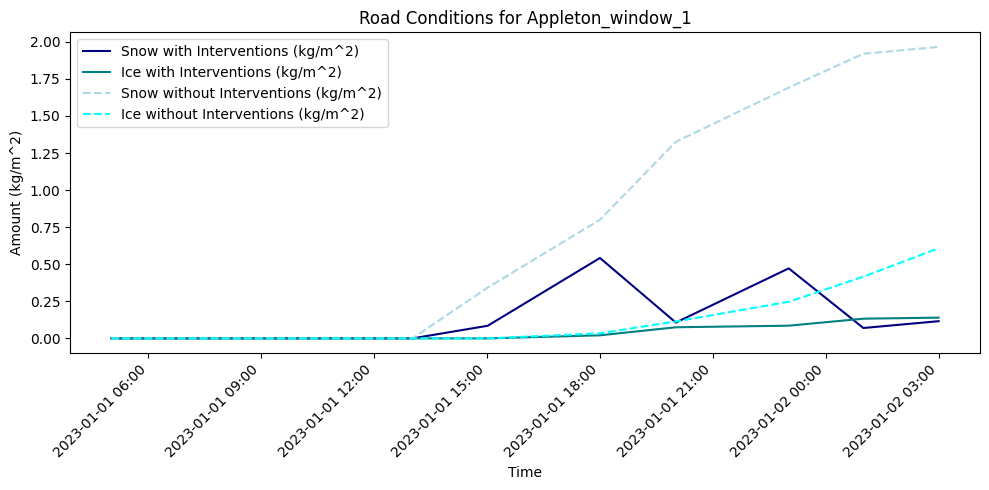

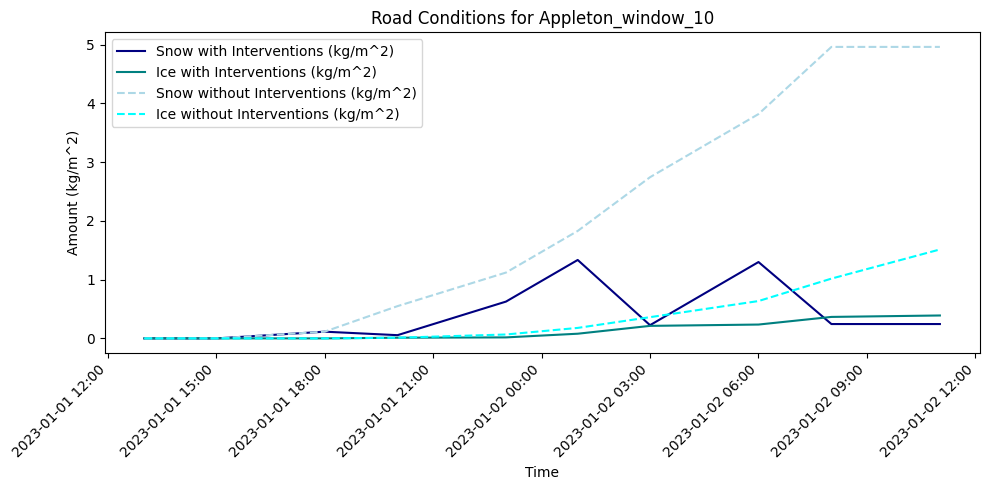

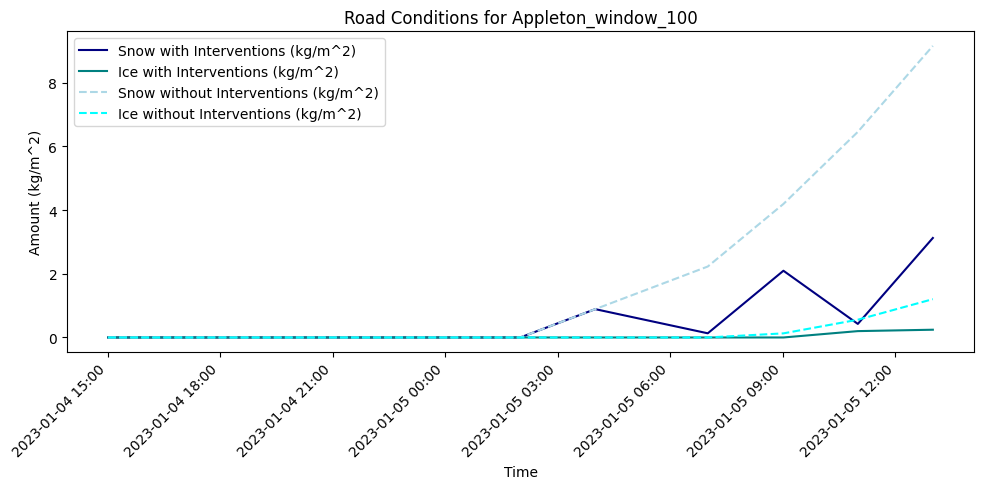

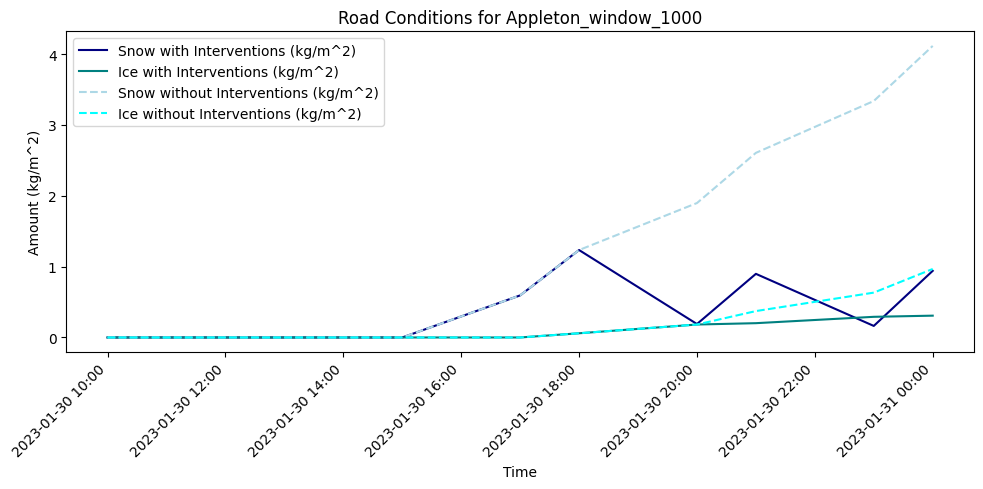

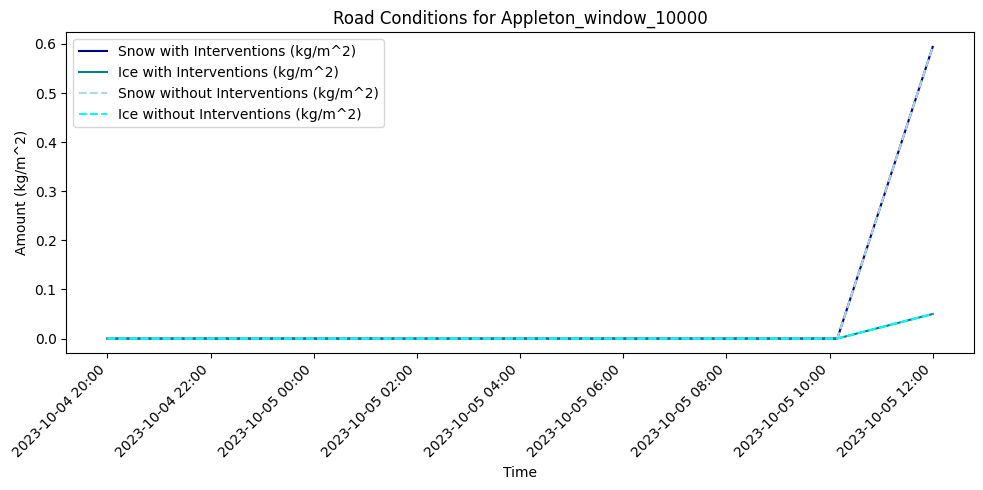

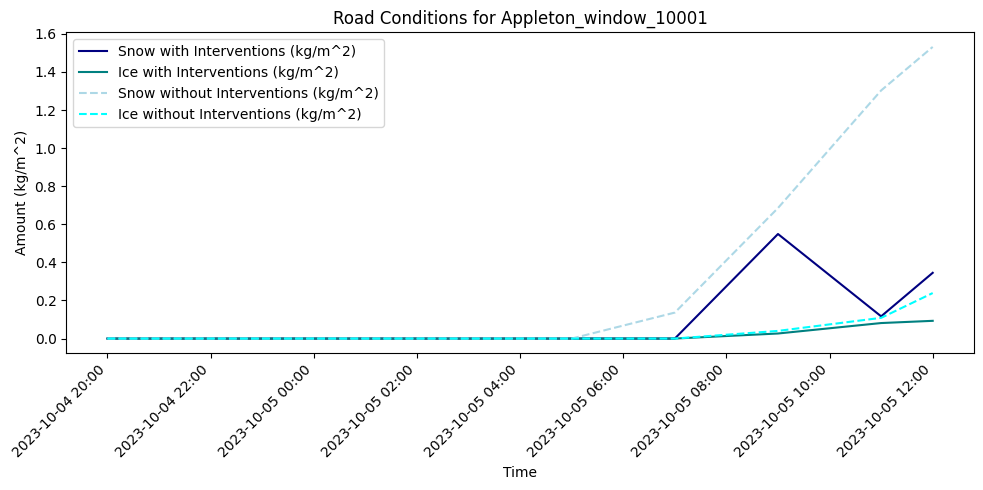

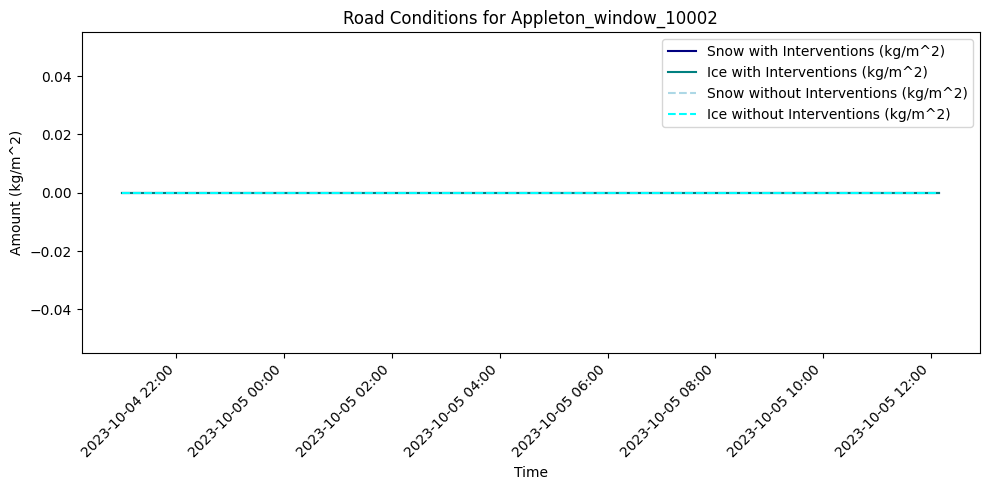

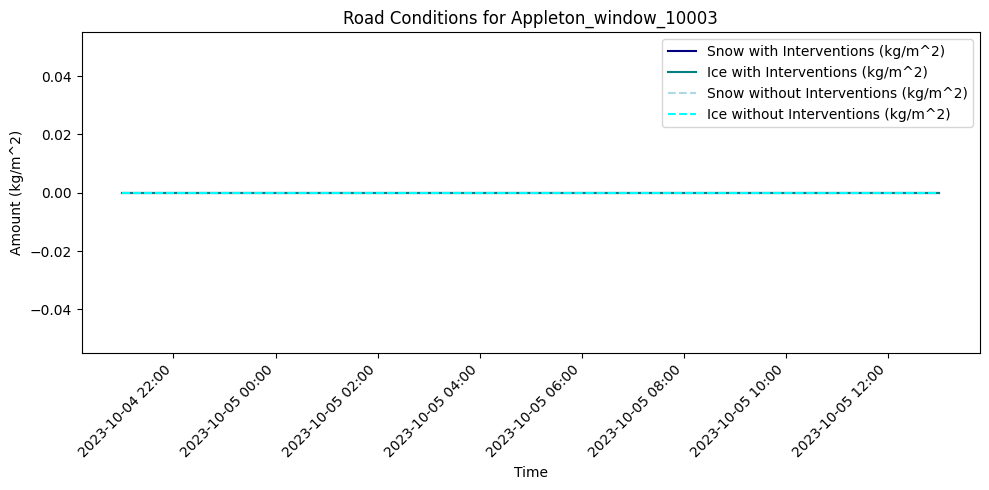

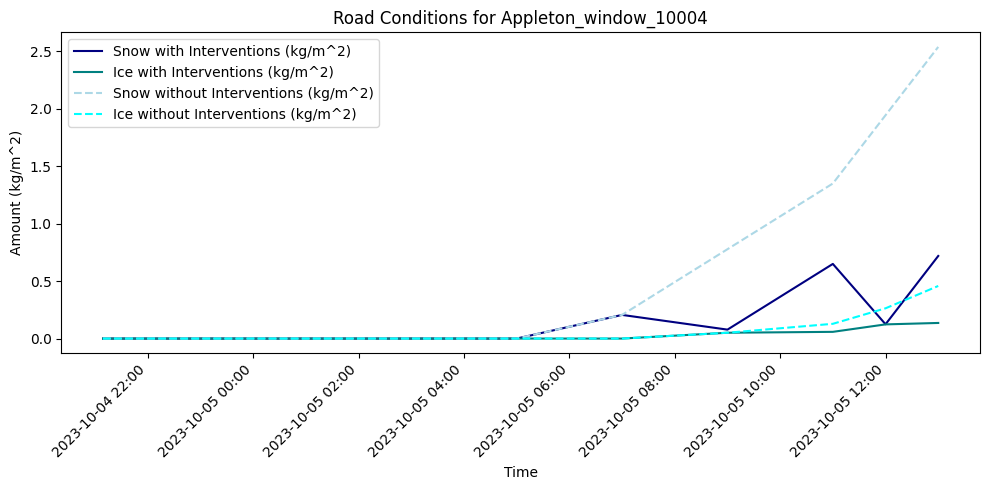

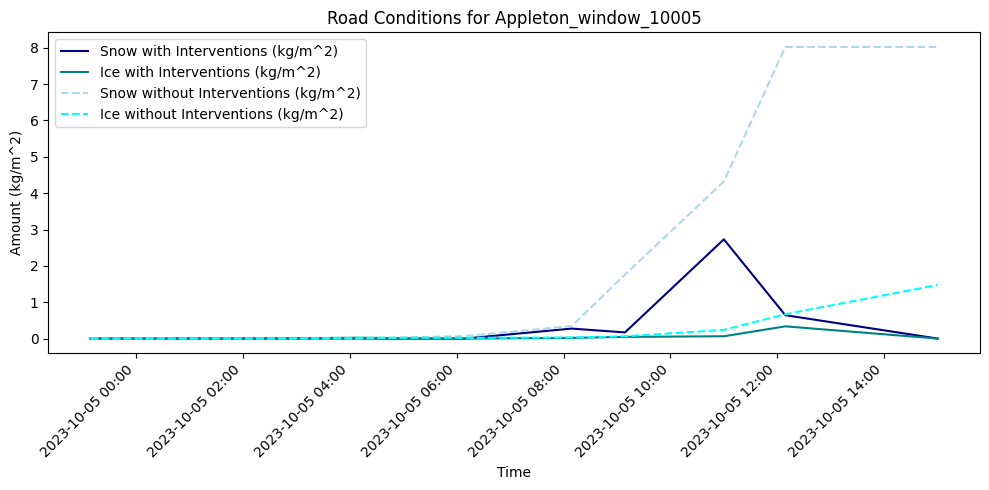

In [66]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates  # Corrected import


# Function to process and visualize the data
def process_and_visualize(csv_path, salt_actions, plow_actions):
    # Read CSV file
    df = pd.read_csv(csv_path, parse_dates=['MeasureTime'])

    # Conversion factors and initial conditions
    initial_conditions = {'initial_Snow': 0, 'initial_water': 0, 'initial_Salt': 0, 'initial_ice': 0, 'plowing':0}

    # Find unique Window_IDs and select the first five
    unique_windows = df['Window_ID'].unique()[:10]

    # Run simulation with and without interventions
    for window in unique_windows:
        # Reset results for each window
        results_with_intervention = {'MeasureTime': [], 'Snow': [], 'Ice': [], 'Salt': [], 'water': []}
        results_without_intervention = {'MeasureTime': [], 'Snow': [], 'Ice': [], 'Salt': [], 'water': []}

        window_data = df[df['Window_ID'] == window]
        # print (window_data)
        
        # Run simulation for current window
        for enable_interventions in [True, False]:
            # Reset initial conditions for each simulation
            initial_conditions = {'initial_Snow': 0, 'initial_water': 0, 'initial_Salt': 0, 'initial_ice': 0, 'plowing':0}
            i = 0
            for index, row in window_data.iterrows():
                # print (i)
                
                if enable_interventions:
                    # Apply plow and salt actions based on the index
                    if  plow_actions[i] == 1:
                        initial_conditions['plowing'] = 1  
                        # print ("start plowing       f ")
                    if salt_actions[i] != 0:
                        initial_conditions['initial_Salt'] = salt_actions[i]
                        # print ("start salting ")
                i +=1
                
                # print ("initial_conditions", initial_conditions)
                # Simulation step
                Air_temp = row['Air TemperatureC']
                Surface_temp = row['Surface TemperatureC']
                Precipitation = row['Precipitation Intensitym/3h'] 
                wind_vel = row['Wind Speed (act)m/s']

                water, salt, ice, snow = Matrial_on_the_road(Air_temp, Surface_temp, Precipitation, wind_vel, **initial_conditions)
                # print ("999999999999999999999water, salt, ice, snow",water, salt, ice, snow)

                # Update initial conditions
                initial_conditions['initial_Snow'] = snow
                initial_conditions['initial_ice'] = ice
                initial_conditions['initial_water'] = water
                initial_conditions['initial_Salt'] = salt
                initial_conditions['plowing'] = 0
                # Store results
                results = results_with_intervention if enable_interventions else results_without_intervention
                results['MeasureTime'].append(row['MeasureTime'])
                results['Snow'].append(snow)
                results['Ice'].append(ice)
                results['Salt'].append(salt if enable_interventions else np.nan)  # Store NaN for salt if no interventions
                results['water'].append(water)

        # Visualization for current window
        fig, ax = plt.subplots(figsize=(10, 5))
        ax.plot(results_with_intervention['MeasureTime'], results_with_intervention['Snow'], label='Snow with Interventions (kg/m^2)', color='navy')
        ax.plot(results_with_intervention['MeasureTime'], results_with_intervention['Ice'], label='Ice with Interventions (kg/m^2)', color='teal')
        ax.plot(results_without_intervention['MeasureTime'], results_without_intervention['Snow'], label='Snow without Interventions (kg/m^2)', color='lightblue', linestyle='--')
        ax.plot(results_without_intervention['MeasureTime'], results_without_intervention['Ice'], label='Ice without Interventions (kg/m^2)', color='cyan', linestyle='--')
        
        ax.set_title(f"Road Conditions for {window}")
        ax.set_xlabel("Time")
        ax.set_ylabel("Amount (kg/m^2)")
        ax.legend()
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M'))
        plt.setp(ax.xaxis.get_majorticklabels(), rotation=45, ha='right')
        plt.tight_layout()
        plt.show()

        # # Print the results for each window
        # print(f"Results for {window}:")
        # print("With Interventions:")
        # print(pd.DataFrame(results_with_intervention).to_string(index=False))
        # print("\nWithout Interventions:")
        # print(pd.DataFrame(results_without_intervention).to_string(index=False))

# Example usage
salt_actions = [0, 0, 0, 0, 400, 0, 0, 0, 0, 0]
plow_actions = [0, 0, 0, 1, 0, 0, 1, 0, 1, 0]
process_and_visualize('Modified_DataSetV8_ConvertedUnits.csv', salt_actions, plow_actions)